In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt

import skimage
from tqdm import tqdm

In [3]:
from riemannianwassersteinflowmatching import RiemannianWassersteinFlowMatching
from emnist import extract_training_samples, extract_test_samples

# Load EMNIST images

In [ ]:


# Mapping for EMNIST 'letters' (1-indexed)
emnist_labels = {
    1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J',
    11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T',
    21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'
}

image_train, label_train = extract_training_samples('letters')
image_test, label_test = extract_test_samples('letters')

image_train, image_test = image_train/255.0, image_test/255.0

label_train = np.asarray([emnist_labels[l] for l in label_train])
label_test = np.asarray([emnist_labels[l] for l in label_test])

In [5]:
image_train = image_train[label_train == 'X']
image_test = image_test[label_test == 'X']

In [6]:
pc_train = [2 * (np.stack(np.where(im > skimage.filters.threshold_otsu(im)), axis = -1))/28 - 1 for im in tqdm(image_train)]
pc_test = [2 * (np.stack(np.where(im > skimage.filters.threshold_otsu(im)), axis = -1))/28 - 1  for im in tqdm(image_test)]

pc_train = [np.clip(pc + np.random.normal(0, 0.02, pc.shape), -0.98 ,0.98) for pc in pc_train]
pc_test = [np.clip(pc + np.random.normal(0, 0.02, pc.shape), -0.98,0.98) for pc in pc_test]

pc_train = [np.stack([pc[:, 1], -pc[:, 0]], axis = 0).T for pc in pc_train]
pc_test = [np.stack([pc[:, 1], -pc[:, 0]], axis = 0).T for pc in pc_test]

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 10532.70it/s]


## Convert to hyperbolic

In [ ]:


def pc_to_hyperbolic(pc, scale = 1.0):
    """
    Lifts a Euclidean point cloud to the Hyperboloid (Lorentz model).
    
    It maps a point p in R^d to x in R^(d+1) such that:
    x = (sqrt(1 + ||p||^2), p)
    
    This ensures <x, x>_L = -1 and x[0] > 0.
    
    :param pc: Input point cloud of shape (N, D)
    :return: Hyperbolic point cloud of shape (N, D+1)
    """
    # 1. Calculate the squared Euclidean norm of the spatial coordinates
    # Shape: (N, 1)

    pc = pc * scale

    spatial_norm_sq = np.sum(pc**2, axis=-1, keepdims=True)
    
    # 2. Solve for the time component (index 0)
    # The constraint is: -x0^2 + ||x_space||^2 = -1
    # Therefore: x0 = sqrt(1 + ||x_space||^2)
    x0 = np.sqrt(1.0 + spatial_norm_sq)
    
    # 3. Concatenate time component as the first axis (standard Lorentz convention)
    # Shape: (N, D+1)
    return np.concatenate([x0, pc], axis=-1)

pc_train = [pc_to_hyperbolic(pc, scale=1) for pc in pc_train]
pc_test = [pc_to_hyperbolic(pc, scale=1) for pc in pc_test]

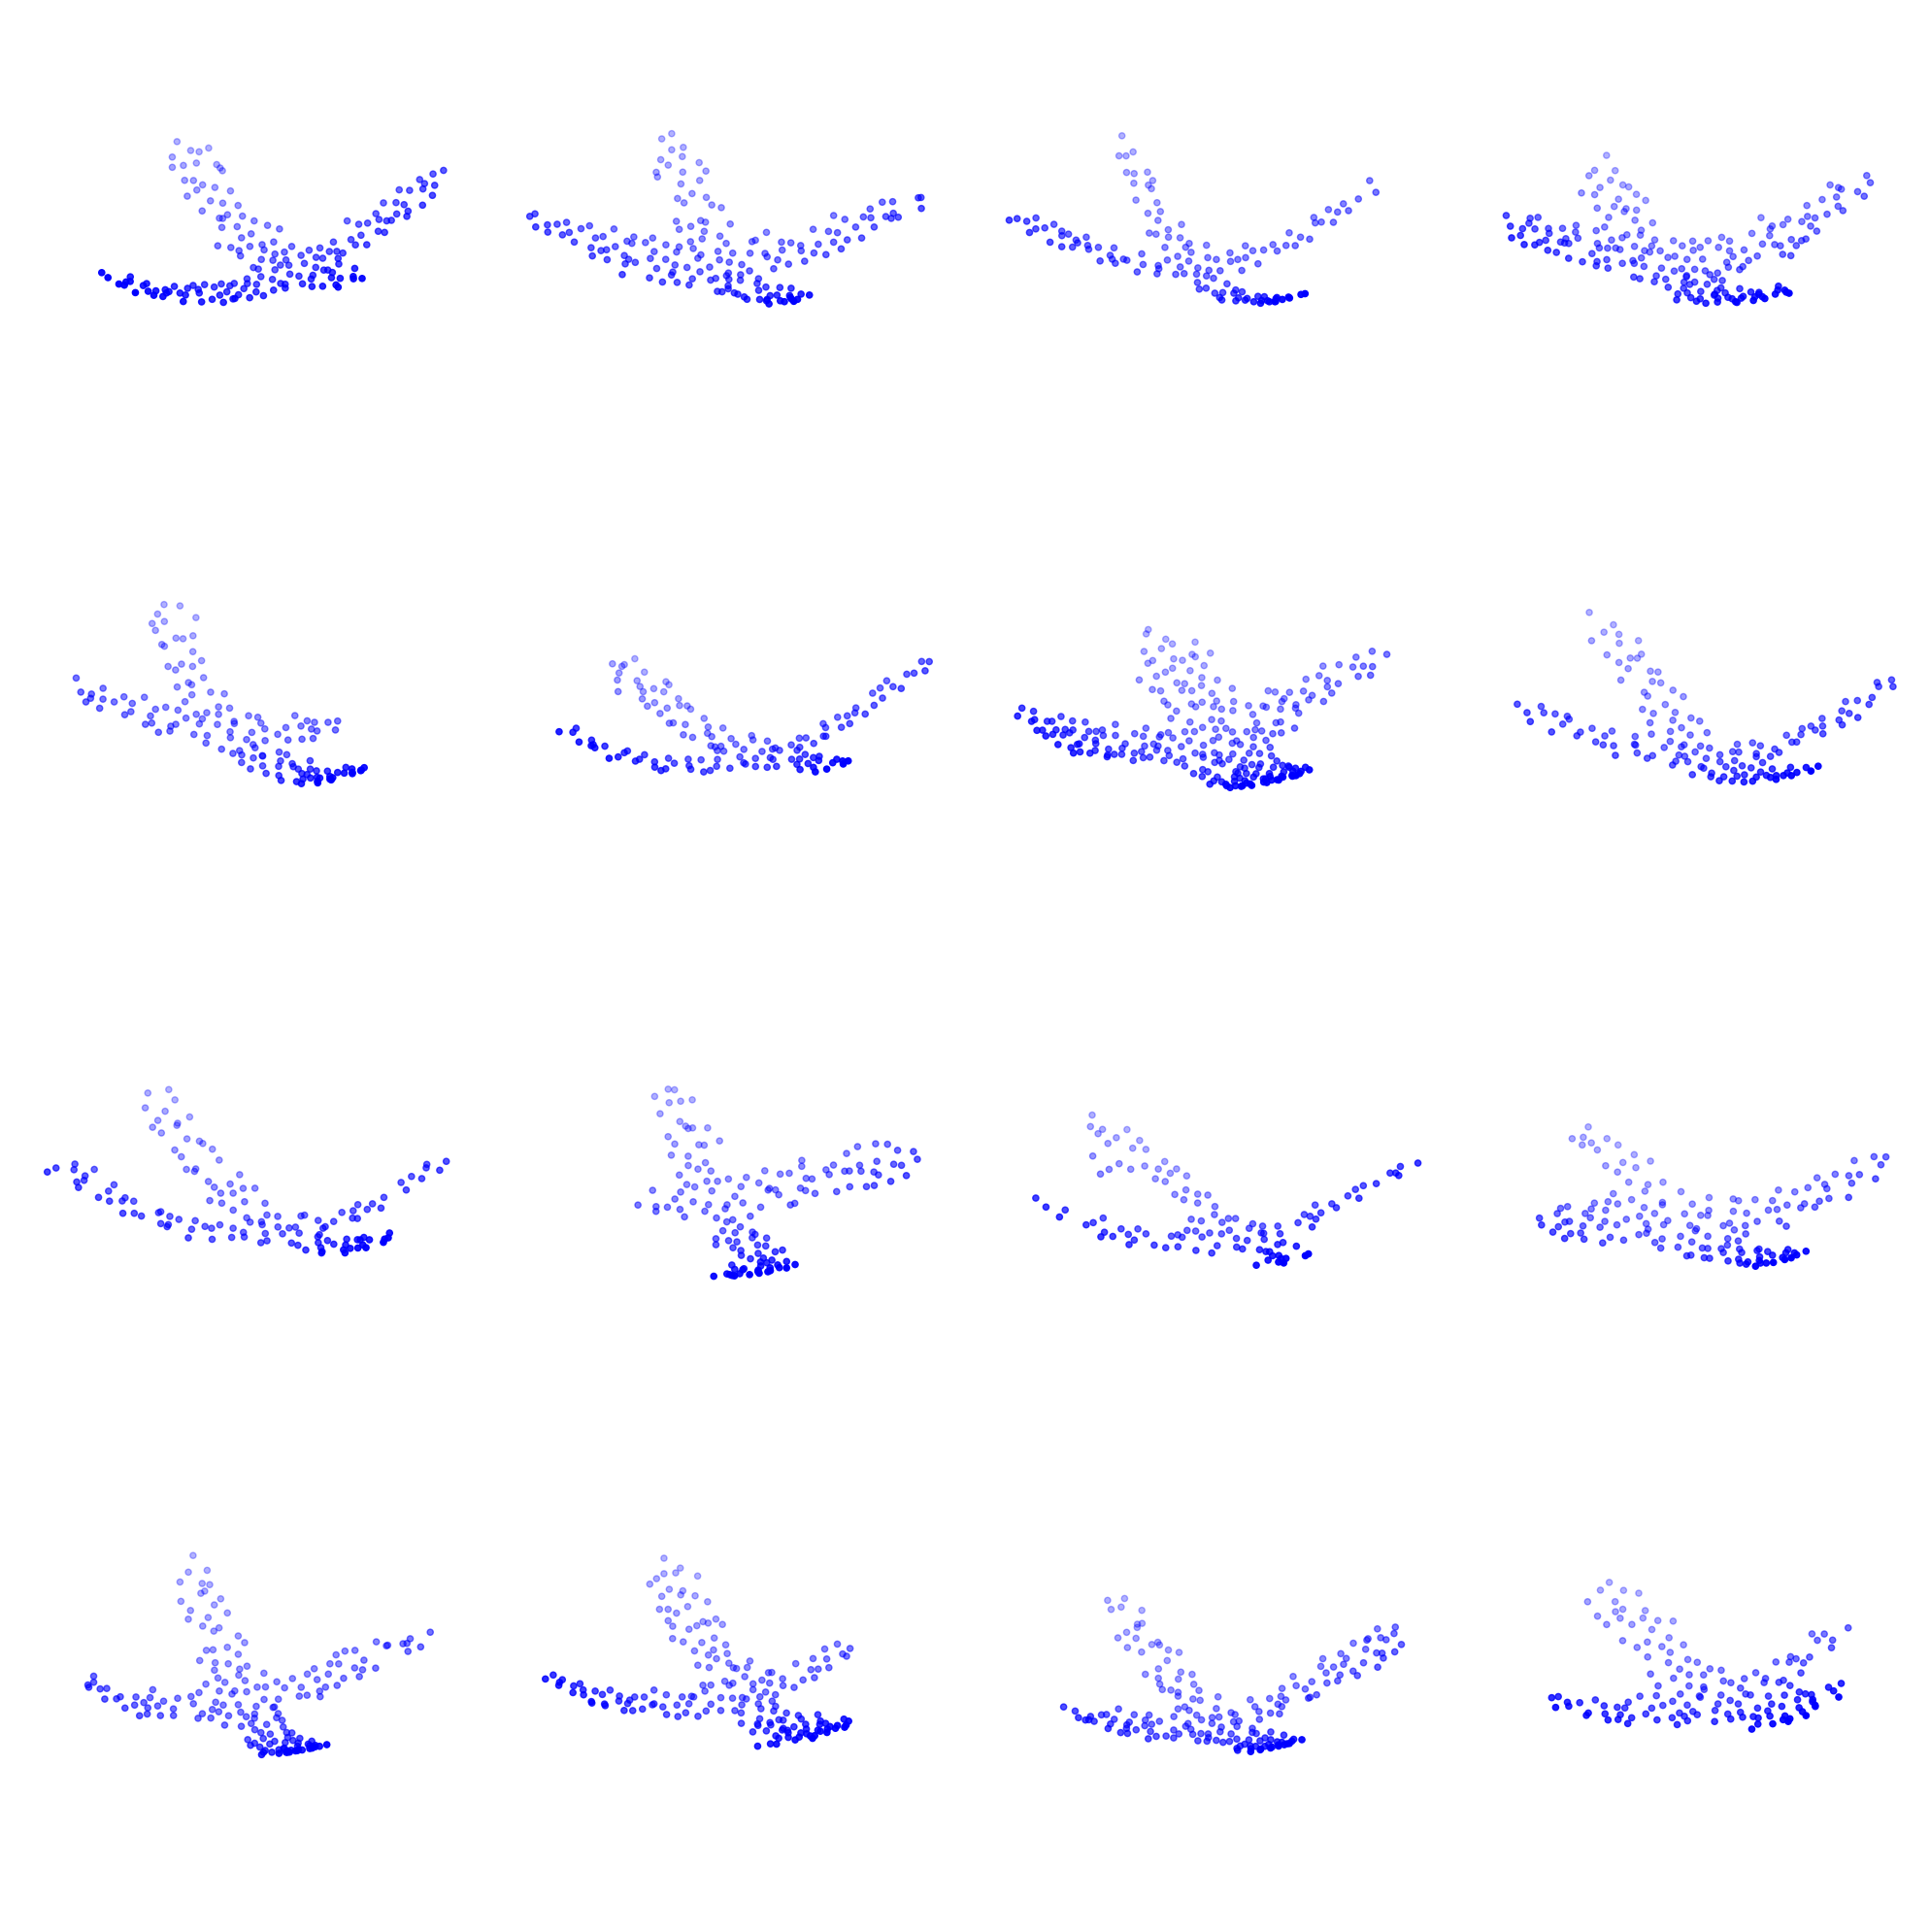

In [8]:
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')


    i = np.random.choice(np.arange(len(pc_train)))
    points = pc_train[i]


    ax.scatter(points[:, 2], 
               -points[:, 1], 
               points[:, 0],  c = 'blue', depthshade=True)




    ax.axis('off')

    
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()


# Run Riemannian Wasserstein Flow Matching

In [9]:

class rwfm_config:
    geom: str = 'hyperbolic'
    monge_map: str = 'entropic'
    wasserstein_eps: float = 0.001
    wasserstein_lse: bool = True
    num_sinkhorn_iters: int = -1
    mini_batch_ot_mode: bool = True
    mini_batch_ot_solver: str = 'chamfer'
    mini_batch_ot_num_iter: int = -1
    minibatch_ot_eps: float = 0.005
    minibatch_ot_lse: bool = True
    noise_type: str = 'ambient_gaussian'
    noise_geom: str = 'hyperbolic'
    embedding_dim: int = 512
    num_layers: int = 6
    num_heads: int = 4
    dropout_rate: float = 0.1
    mlp_hidden_dim: int = 512
    cfg: bool = False
    p_cfg_null: float = 0.0
    w_cfg: float = 1.0
    normalized_condition: bool = False

 


FlowMatchingModel = RiemannianWassersteinFlowMatching(point_clouds = pc_train, 
                                                      config = rwfm_config)



Initializing WassersteinFlowMatching
Using hyperbolic geometry
Projecting point clouds to geometry (with cpu)...


100%|███████████████████████████████████| 4800/4800 [00:00<00:00, 150704.84it/s]


Using hyperbolic geometry for noise


Estimating Gaussian Params: 100%|███████████████| 10/10 [00:01<00:00,  6.15it/s]


Using ambient_gaussian noise for hyperbolic geometry.
Noise parameters:
  mean: [ 1.1321021  -0.04383816  0.02250095]
  cov_chol_mean: [[ 0.10419136  0.          0.        ]
 [-0.02196326  0.32925254  0.        ]
 [ 0.02758464  0.06765626  0.3772339 ]]
  cov_chol_std: [[0.01398235 0.         0.        ]
 [0.05637791 0.05255737 0.        ]
 [0.06562829 0.11948882 0.05291542]]
  noise_df_scale: 1.0
Finding optimal number of Sinkhorn iterations...
INFO: Found sufficient convergence (95%) at 570 iterations.
Auto-selected 570 Sinkhorn iterations.
Using entropic map with 570 iterations and 0.001 epsilon
Chamfer Mini-Batch
Finding optimal number of Sinkhorn iterations for Mini-Batch OT...
Auto-selected 120 Sinkhorn iterations for Mini-Batch OT.


## Train Model

Train Model & Plot loss curve

In [10]:

FlowMatchingModel.train(batch_size = 32, 
                        training_steps = 500000, 
                        decay_steps = 5000)

Creating new train state
Train state created


: 1.149e-02: 100%|████████████████████| 500000/500000 [3:43:45<00:00, 37.24it/s]


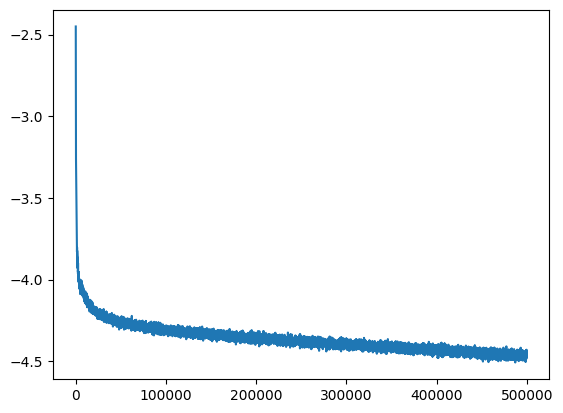

In [11]:
loss_smooth = np.convolve(np.log(FlowMatchingModel.losses), np.ones(100)/100, mode='valid')
plt.plot(loss_smooth)

# Generate Samples

Set Initial Key

In [24]:
key = jax.random.PRNGKey(42)

Run Flow for 1000 timesteps

In [25]:

subkey,key = jax.random.split(key)
generated_samples, sample_weights = FlowMatchingModel.generate_samples(num_samples = 16,
                                                            timesteps = 1000,
                                                            key = subkey)

Plot resulting point clouds

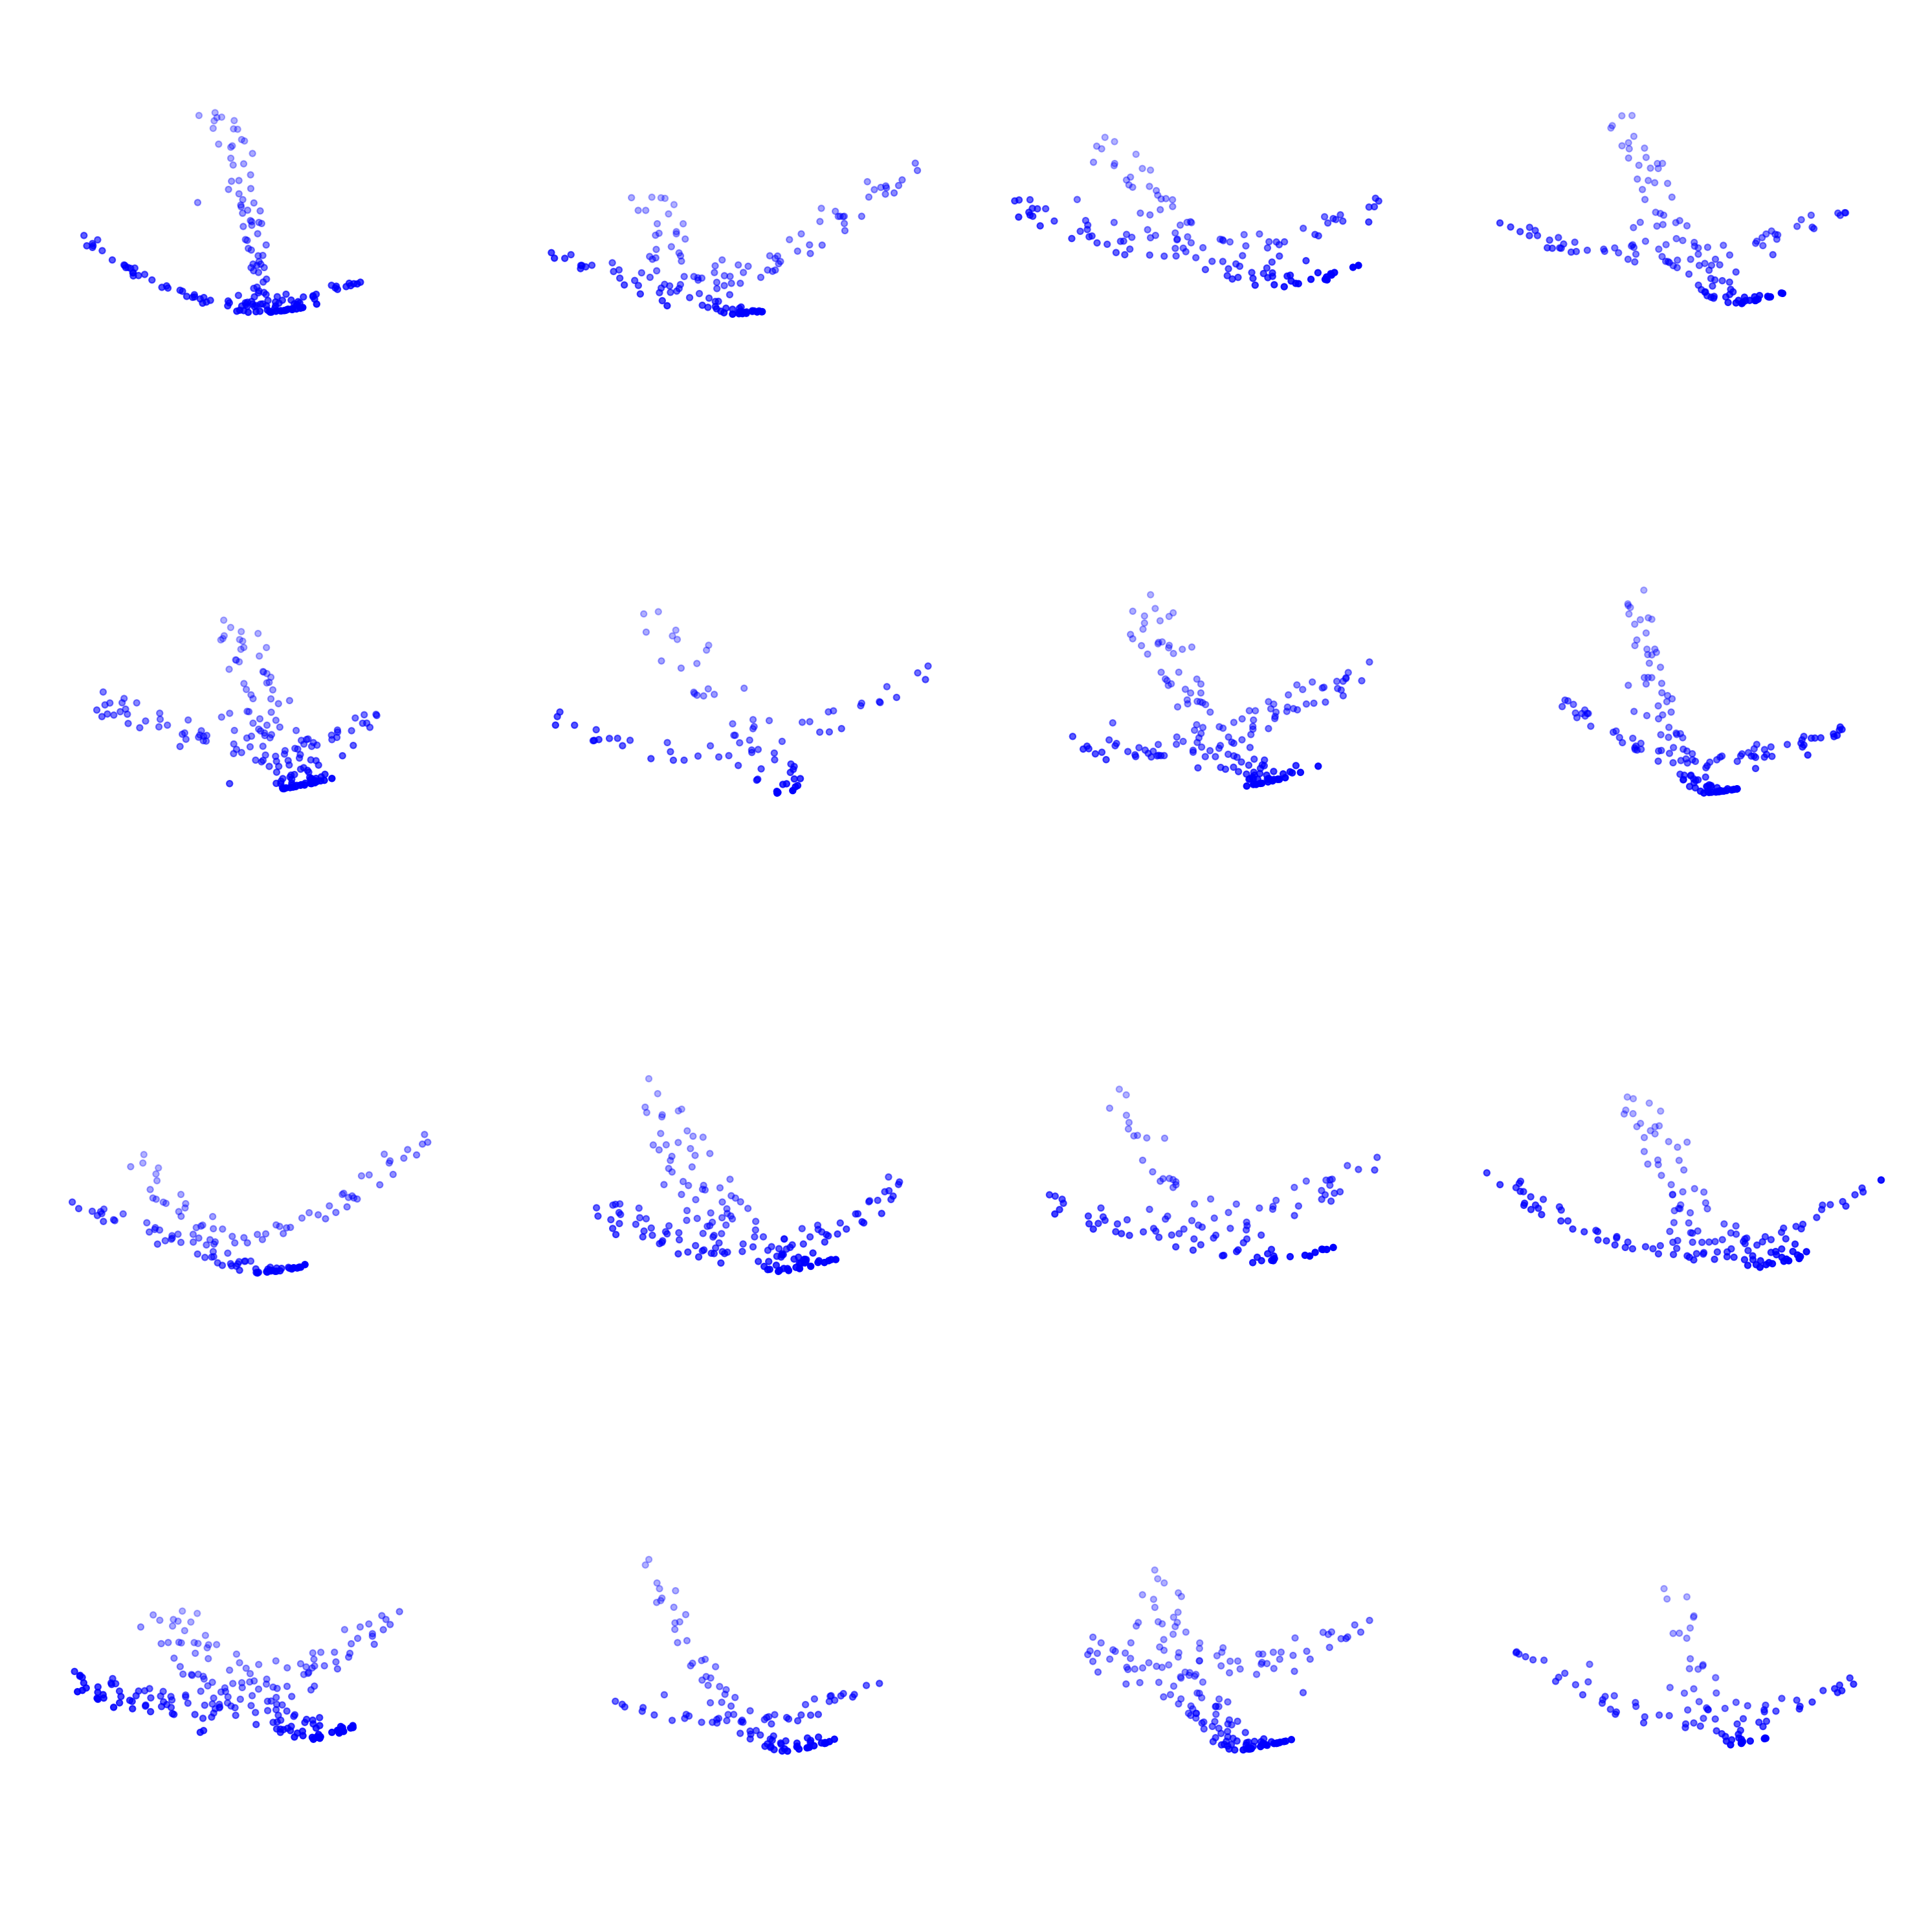

In [37]:
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')

    points = generated_samples[-1][ind][sample_weights[ind]>0]


    ax.scatter(points[:, 2], 
               -points[:, 1], 
               points[:, 0],  c = 'blue', depthshade=True)


    ax.axis('off')
    
    plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


# animate in poincare space

In [32]:
import matplotlib.animation
from matplotlib.widgets import Slider


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

def lorentz_to_poincare(points):
    """
    Maps points from the Lorentz model (x0, x1, x2) to the Poincaré disk (y1, y2).
    y = x[1:] / (1 + x[0])
    """
    return points[:, 1:] / points[:, 0:1]


In [ ]:
fig = plt.figure(figsize=(5, 5)) 

def animate_timestep(t):

    plt.clf()
    ax = fig.add_subplot(1, 1, 1)

    points_poincare = lorentz_to_poincare(generated_samples[t][3][sample_weights[3]>0])

    # 1. Draw Boundary Circle
    boundary = plt.Circle((0, 0), 1, fill=False, color='#546E7A', linewidth=2.0)
    ax.add_patch(boundary)

    # 2. Draw "Polar" Grid (Geodesics through origin & Hyperbolic circles)
    # Radial lines (Geodesics passing through the origin are straight lines)
    for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
        ax.plot([0, np.cos(angle)], [0, np.sin(angle)], color='#546E7A', alpha=0.3, lw=1, zorder=0)

    # Concentric circles (Euclidean circles centered at origin correspond to hyperbolic circles)
    # We plot circles at Euclidean radii corresponding to hyperbolic distances
    for r in [0.2, 0.4, 0.6, 0.8]:
        circ = plt.Circle((0, 0), r, fill=False, color='#546E7A', alpha=0.3, lw=1, linestyle=':', zorder=0)
        ax.add_patch(circ)

    # 3. Plot Points
    ax.scatter(points_poincare[:, 0], points_poincare[:, 1], 
            s=20, c='#FFB347', alpha=0.9, edgecolors='white', linewidth=0.5, zorder=2)

    # Styling
    ax.set_aspect('equal')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.axis('off')

    plt.tight_layout()

In [39]:


anim = matplotlib.animation.FuncAnimation(fig, animate_timestep, frames=np.linspace(0, generated_samples.shape[0]-1, 50).astype('int'))

In [40]:
anim